# Introduction

## Open-source software to process PAM data stored in the cloud 

As oceanic passive acoustic monitoring (PAM) datasets grow in volume and global coverage, the challenges of data storage and processing also grow.  This Python notebook illustrates recent developments in open-source software that help to address these challenges by:
1. pulling PAM metadata and data directly from a cloud storage platform into a data processing environment, and
2. producing standard data products that succinctly describe the ocean soundscape and its variations using hybrid millidecade band (HMB) spectra (Martin et al., 2021).

For illustration purposes here, we will process a single day of audio data using [PyPAM Based Processing (PBP)](https://github.com/mbari-org/pbp) to produce (a) an essential quality-control plot, (b) a daily netCDF file containing HMB spectra at 1 minute resolution, and (c) a summary plot of the HMB spectra.  Batch processing of longer time-series can also be accomplished in a Python notebook using PBP, however more powerful deployment strategies are preferred for batch processing with PBP at scale.

The monitoring location for this example is [La Cruz Canyon](https://nmsmontereybay.blob.core.windows.net/montereybay-prod/media/research/techreports/sesaquicklook/sesa15quicklook_2016.pdf), a Sanctuary Ecologically Sensitive Area (SESA) in Monterey Bay National Marine Sanctuary.  Data from this site are stored in [AWS S3](https://aws.amazon.com/s3/) cloud storage.

# Generate and review temporal metadata

Essential to reliable processing of any PAM data time-series, regardless of duration, is reliable temporal metadata.  To help ensure reliable processing, PBP interactively generates temporal metadata and allows the user to review it before proceeding with processing.  If the start times and durations of all relevant audio files are accurately specified, mapping of input audio data to output analysis products will be accurate.  If it is requrired to first correct known inaccuracies in available temporal metadata, PBP includes methods to apply such corrections.

Let's extract temporal metadata from input audio files stored in the cloud, for a specified time period.  The recorder for this location stores temporal metadata for each audio file in a separate xml file, and we use these xml files here.  The code below will generate essential temporal metadata for a brief period and store it in daily files in [json format](https://www.json.org/json-en.html).

In [23]:
# Audio data input specifications
wav_uri              = 's3://pacific-sound-mb05'   # cloud storage location for the input audio data
wav_prefix           = '6715'       # prefix for the audio files
start_date           = '20220922'   # start date for temporal metadata extraction (YYYYMMDD) 
end_date             = '20220925'   # end date for temporal metadata extraction (YYYYMMDD) 
json_base_dir        = 'metadata/json' # location to store generated metadata in JSON format
xml_dir              = 'metadata/xml' # location to store downloaded xml files from the soundtrap 

# Import package modules
from pbp.meta_gen.gen_soundtrap import SoundTrapMetadataGenerator
from pbp.logging_helper import create_logger_info
from datetime import datetime

 # a logger that only logs messages tagged as info to the console, for more verbose logging
log = create_logger_info(f'soundtrap_{start_date}_{end_date}')

# Convert the start and end dates to datetime objects
start = datetime.strptime(start_date, "%Y%m%d")
end = datetime.strptime(end_date, "%Y%m%d")

# Create the metadata generator
meta_gen = SoundTrapMetadataGenerator(
        log=log,
        uri=wav_uri,
        json_base_dir=json_base_dir,
        xml_dir=xml_dir,
        start=start,
        end=end,
        prefixes=[wav_prefix])

# Generate the metadata - this will generate JSON files in the json_base_dir
meta_gen.run()

Searching in s3://pacific-sound-mb05/*.wav for wav files that match the prefixes ['6715']* ...
Searching in bucket: pacific-sound-mb05 for .wav and .xml files between 2022-09-21 00:00:00 and 2022-09-26 00:00:00
Found 20 files to process that covers the expanded period 2022-09-21 00:00:00 - 2022-09-26 00:00:00
Done correcting metadata for 2022-09-22 00:00:00. Saved to metadata/json/2022/20220922.json
Done correcting metadata for 2022-09-23 00:00:00. Saved to metadata/json/2022/20220923.json
Done correcting metadata for 2022-09-24 00:00:00. Saved to metadata/json/2022/20220924.json
Done correcting metadata for 2022-09-25 00:00:00. Saved to metadata/json/2022/20220925.json
Coverage plot saved to metadata/json/soundtrap_coverage_20220922_20220925.jpg


## View daily json files
When this processing completes (in about 5 seconds), you can find and view the temporal metadata files that were just created within the directory structure of the notebook.  You will see a directory structure similar to this:

```
metadata/json/
└── 2020
    ├── 20220922.json
    ├── 20220923.json
    ├── ...
└── soundtrap_coverage_20220922_20220925.jpg
```

The command below will list all of the daily files.

In [24]:
!ls -l {json_base_dir}/2022

total 36
-rw-r--r-- 1 jovyan users 1105 Aug 24 02:50 20220801.json
-rw-r--r-- 1 jovyan users 1084 Aug 24 02:50 20220802.json
-rw-r--r-- 1 jovyan users 1098 Aug 24 02:50 20220803.json
-rw-r--r-- 1 jovyan users 1105 Aug 24 02:50 20220804.json
-rw-r--r-- 1 jovyan users 1098 Aug 24 02:50 20220805.json
-rw-r--r-- 1 jovyan users 1084 Sep 19 03:00 20220922.json
-rw-r--r-- 1 jovyan users 1098 Sep 19 03:00 20220923.json
-rw-r--r-- 1 jovyan users 1098 Sep 19 03:00 20220924.json
-rw-r--r-- 1 jovyan users 1112 Sep 19 03:00 20220925.json


Each daily json file provides the essential temporal metadata for each file that contains data for the day being processed.  

We can view the contents of a daily json file below.

In [25]:
import json

# Load JSON data from a file and print it
with open(f'{json_base_dir}/2022/20220922.json', 'r') as file:
    data = json.load(file)
 
print(json.dumps(data, indent=4))

[
    {
        "uri": "s3://pacific-sound-mb05/6715.220921234729.wav",
        "start": "2022-09-21T23:47:29Z",
        "end": "2022-09-22T05:47:28Z",
        "duration_secs": 21599.2573333333,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-mb05/6715.220922054727.wav",
        "start": "2022-09-22T05:47:27Z",
        "end": "2022-09-22T11:47:26Z",
        "duration_secs": 21599.224,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-mb05/6715.220922114725.wav",
        "start": "2022-09-22T11:47:25Z",
        "end": "2022-09-22T17:47:24Z",
        "duration_secs": 21599.386,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-mb05/6715.220922174724.wav",
        "start": "2022-09-22T17:47:24Z",
        "end": "2022-09-22T23:47:23Z",
        "duration_secs": 21599.253,
        "channels": 1
    },
    {
        "uri": "s3://pacific-sound-mb05/6715.220922234722.wav",
        "start": "2022-09-22T23:47:22Z",
        "end": "2022

## View daily temporal coverage plot
The temporal metadata generation also creates a summary plot that shows the percentage of each day that has audio data coverage.

![example plot](metadata/json/soundtrap_coverage_20220922_20220925.jpg)

In this example, the temporal metadata indicate that each of the days within this brief period was fully sampled.

It is important that the person responsible for processing a time-series first ensure that temporal coverage of input audio data is as-expected for the period to be processed.  This essential screening can identify issues such as previously unknown data gaps resulting from incomplete copying of part of the recording time-series to the storage archive.  If this plot shows the expected coverage, processing can proceed.

# Specify other processing metadata

We next specify other metadata related to the audio recorder and the processing job.

In [26]:
# hydrophone specifications
sensitivity_flat_value = 176   # from Ocean Instruments calibration database, recorder #6715
voltage_multiplier   = 1       # no change to raw audio required to account for PkPk voltage
subset_to            = (10, 24000)   # subset frequency band for output HMB spectra, recording @ 48 kHz

# metadata files for output netCDF data products
global_attrs_uri     = 'metadata/attribute/globalAttributes_MB05.yaml'  
variable_attrs_uri   = 'metadata/attribute/variableAttributes_MB05.yaml'

# output file locations
download_dir         = 'downloads'   # audio files are stored here while being processed
output_dir           = 'output'      # directory to store daily netCDF results and plots
output_prefix        = 'MB05_'       # a prefix for the name of generate files

# select a day to process (YYYYMMDD format)
date = '20220922'

# Process a day of audio data

With complete metadata specification, we can proceed to producing a daily netCDF file of HMB spectra.  

When processing large data audio archives at scale, processing steps simply occur in sequence.  For the purposes of illustration in this notebook, the main steps are detailed sequentially:
- Import package modules
- Create `HmbGen` object with the parameters 
- Generate the core data product: a netCDF file of 1-minute HMB spectra
- Generate a summary plot from the netCDF file

## Import package modules

In [27]:
from pbp.simpleapi import HmbGen

from pbp import get_pbp_version
get_pbp_version()

'1.4.8'

In [28]:
# In this notebook we fetch audio files from public S3 buckets:
import boto3
import botocore
from botocore.config import Config

## Create an `HmbGen` object with the parameters

In [29]:
hmb_gen = HmbGen()

hmb_gen.set_json_base_dir(json_base_dir)
hmb_gen.set_global_attrs_uri(global_attrs_uri)
hmb_gen.set_variable_attrs_uri(variable_attrs_uri)
hmb_gen.set_sensitivity(sensitivity_flat_value)
hmb_gen.set_voltage_multiplier(voltage_multiplier)
hmb_gen.set_subset_to(subset_to)

config = Config(signature_version=botocore.UNSIGNED)
s3_client = boto3.client('s3', config=config)
hmb_gen.set_s3_client(s3_client)

hmb_gen.set_download_dir(download_dir)
hmb_gen.set_output_dir(output_dir)
hmb_gen.set_output_prefix(output_prefix)

hmb_gen.set_print_downloading_lines(True)

# ----- JUST FOR INITIAL CONVENIENCE: ------
hmb_gen.set_retain_downloaded_files(True)                                    
hmb_gen.set_assume_downloaded_files(True)

## Check parameters

In [30]:
error = hmb_gen.check_parameters()
# A message is returned in case of any errors
if error:
    raise RuntimeError(f"check_parameters returned:\n{error}")

## Generate HMB product


In [31]:
result = hmb_gen.process_date(date)

# The resulting NetCDF file should have been saved under the output directory.

# Here we expose the generated dataset itself to see it displayed in the notebook:
result.dataset

pbp v1.4.8: : Processing 20220922 to generate output/MB05_20220922.nc...
::: Started processing date='20220922'
Assuming already downloaded s3://pacific-sound-mb05/6715.220921234729.wav
Assuming already downloaded s3://pacific-sound-mb05/6715.220922054727.wav
Assuming already downloaded s3://pacific-sound-mb05/6715.220922114725.wav
Assuming already downloaded s3://pacific-sound-mb05/6715.220922174724.wav
Assuming already downloaded s3://pacific-sound-mb05/6715.220922234722.wav
Unable to save output/MB05_20220922.nc: Unable to synchronously create file (unable to truncate a file which is already open)
:::   Ended processing date='20220922' =>  nc_filename='output/MB05_20220922.nc'


<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2167, 1: 1)
Coordinates:
  * time         (time) int64 1663804800 1663804860 ... 1663891080 1663891140
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 2.391e+04 2.396e+04
Dimensions without coordinates: 1
Data variables:
    psd          (time, frequency) float32 62.87 63.59 65.3 ... 39.2 39.13 39.21
    effort       (time) float32 60.0 60.0 60.0 60.0 60.0 ... 60.0 60.0 60.0 60.0
    sensitivity  (1) float32 176.0
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    Summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  SanctSound MB05 mooring
    instrument:                SoundTrap ST600 HF, SN 6999
    cdm_data_type:             TimeSeries
    references:                Computation of single-sided mean-square sound ...

## Generate summary plot

We can use the `plot_dataset_summary` function in mbari-pbp:

In [33]:
from pbp.plotting import plot_dataset_summary
import xarray as xr

In [34]:
nc_filename = 'output/MB05_20220922.nc'
ds = xr.open_dataset(nc_filename, engine="h5netcdf")

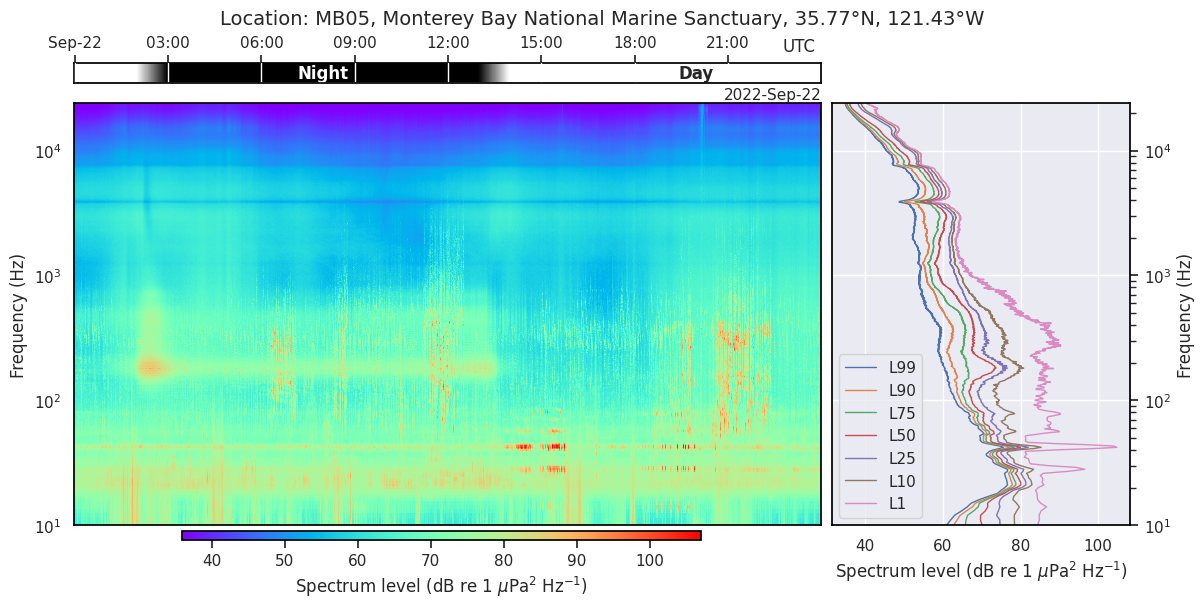

In [35]:
### ****NOTE**** Review parameters below

plot_dataset_summary(
    ds,
    lat_lon_for_solpos=(35.77, -121.43),
    title='Location: MB05, Monterey Bay National Marine Sanctuary, 35.77°N, 121.43°W',
    ylim=(10, 24000),
    cmlim=(36, 107),
    show=True,
)